In [4]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nevret93","key":"02828d578cd0ace8e5bf51cf06cb0c63"}'}

In [5]:
ls -1ha kaggle.json

kaggle.json


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning이 일어나지 않도록
!chmod 600 ~/.kaggle/kaggle.json

## Credit card fraud

In [7]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

 97% 64.0M/66.0M [00:00<00:00, 63.0MB/s]
100% 66.0M/66.0M [00:00<00:00, 84.7MB/s]


In [8]:
!ls

creditcardfraud.zip  kaggle.json  sample_data


In [9]:
!unzip creditcardfraud

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


---

In [0]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import collections
from tqdm import tqdm, tqdm_notebook

# PyTorch Packages
import torch.nn as nn
from torch.autograd import Variable as V
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader

# SKLearn Packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score)
from sklearn.metrics import accuracy_score, precision_score

# Plotting packages
import matplotlib.pyplot as plt
%matplotlib inline
from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.models import HoverTool, NumeralTickFormatter
from bokeh.palettes import Set3_12
from bokeh.transform import jitter

In [0]:
output_notebook()

In [0]:
df = pd.read_csv('creditcard.csv')

In [22]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [0]:
df['TimeNorm'] = df['Time'].apply(lambda x: np.ceil(float(x)/3600) % 24.)

In [0]:
def format_plot(p, x_label, y_label):
    p.grid.grid_line_color = None
    p.background_fill_color = 'whitesmoke'
    p.axis.minor_tick_line_color = None
    p.title.align = 'center'
    p.title.text_font_size = '18px'
    p.xaxis.axis_label = x_label
    p.yaxis.axis_label = y_label
    p.xaxis.axis_label_text_font_size = '14px'
    p.yaxis.axis_label_text_font_size = '14px'
    p.yaxis.axis_line_color = None
    p.yaxis.major_tick_line_color = None
    p.axis.major_label_text_font_size = '12px'

    return p

In [25]:
# Get only fraud transactions
fraud_df = df[df['Class'] == 1]
f_source = ColumnDataSource(data = dict(x = fraud_df['TimeNorm'].values, y = fraud_df['Amount'].values))

# get only normal transactions
non_fraud_df = df[df['Class'] == 0]

# Limit amount of data in plot
sample_non_fraud = df.sample(frac=0.01, replace=False)
norm_source = ColumnDataSource(data = dict(x = sample_non_fraud['TimeNorm'].values, y = sample_non_fraud['Amount'].values))

# create Bokeh figure
p = figure(plot_width = 800,
           toolbar_location = None,
           title = 'Transactions by Time and Amount')

# plot Normal Transactions
p.circle(x=jitter('x', width = 0.9, range = p.x_range),
         y = 'y', color = Set3_12[4],
         fill_alpha = 0.1,
         source = norm_source)

# plot Fraud Transactions
p.circle(x=jitter('x', width = 0.9, range = p.x_range),
         y = 'y', color = Set3_12[3],
         fill_alpha = 0.7,
         source = f_source)

# function to format plot
p = format_plot(p, 'Time', 'Amount')

p.yaxis[0].formatter = NumeralTickFormatter(format='$0,0')

show(p)

In [26]:
df.loc[df['Class'] == 1, 'Amount'].max()

2125.87

## Data Normalization

네트워크가 잘 학습할 수 있도록 StandardScaler()로 정규화한다.

In [0]:
ss = StandardScaler()
df['TimeNorm'] = ss.fit_transform(df['TimeNorm'].values.reshape(-1, 1))
df['NormAmt'] = ss.fit_transform(df['Amount'].values.reshape(-1, 1))

In [0]:
df = df.drop(['Time', 'Amount'], axis = 1)

In [0]:
X_train, X_test = train_test_split(df, test_size = 0.2, random_state = 42)

Normal 데이터만을 학습해야하므로 Normal과 Fraud를 구분한다.

In [32]:
X_train = X_train[X_train['Class'] == 0]            # Normal data
X_train = X_train.drop('Class', axis = 1)           # drop Class column

y_test = X_test['Class'].values                     # y_test는 X_test의 Class를 저장
X_test = X_test.drop('Class', axis = 1)             # drop Class column

X_test = X_test.values
X_train = X_train.values

X_train.shape, X_test.shape

((227451, 30), (56962, 30))

Numpy 배열을 Pytorch Float 텐서로 바꾸고 DataLoader로 load한다.

In [0]:
Xt = torch.FloatTensor(X_train)
Xtr = torch.FloatTensor(X_test)
Xdl = DataLoader(Xt, batch_size = 1000)
tdl = DataLoader(Xtr, batch_size = 1000)

## Autoencoder Model

In [0]:
class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(30, 20)
        self.lin2 = nn.Linear(20, 10)
        self.lin7 = nn.Linear(10, 20)
        self.lin8 = nn.Linear(20, 30)

        self.drop2 = nn.Dropout(0.05)

        self.lin1.weight.data.uniform_(-2, 2)
        self.lin2.weight.data.uniform_(-2, 2)
        self.lin7.weight.data.uniform_(-2, 2)
        self.lin8.weight.data.uniform_(-2, 2)

    def forward(self, data):
        x = F.tanh(self.lin1(data))
        x = self.drop2(F.tanh(self.lin2(x)))
        x = F.tanh(self.lin7(x))
        x = self.lin8(x)

        return (x)

In [0]:
def score(x):
    y_pred = model(V(x))
    x1 = V(x)

    return loss(y_pred, x1).data

In [0]:
# Utilize a named tuple to keep track of scores at each epoch
model_hist = collections.namedtuple('Model', 'epoch loss val_loss')
model_loss = model_hist(epoch = [], loss = [], val_loss = [])

In [0]:
def train(epochs, model, model_loss):
    try:c = model_loss.epoch[-1]
    except: c = 0
    for epoch in tqdm_notebook(range(epochs), position = 0, total = epochs):
        losses = []
        dl = iter(Xdl)
        for t in range(len(dl)):
            # Forward pass: compute predicted y and loss by passing x to the model.
            Xt = next(dl)
            y_pred = model(V(Xt))

            l = loss(y_pred, V(Xt))
            losses.append(l)
            optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to model parameters
            l.backward()

            # Calling the step function on an Optimizer makes an update to its parameters
            optimizer.step()

        val_dl = iter(tdl)
        val_scores = [score(next(val_dl)) for i in range(len(val_dl))]

        model_loss.epoch.append(c+epoch)
        model_loss.loss.append(l.data)
        model_loss.val_loss.append(np.mean(val_scores))
        print(f'Epoch: {epoch}  Loss: {l.data:.4f}   Val_Loss: {np.mean(val_scores):.4f}')

## Model Training

In [0]:
model = Net1()
loss = nn.MSELoss()
learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [58]:
train(model = model, epochs = 100, model_loss = model_loss)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch: 0  Loss: 0.3655   Val_Loss: 0.4622
Epoch: 1  Loss: 0.3794   Val_Loss: 0.4565
Epoch: 2  Loss: 0.3578   Val_Loss: 0.4574
Epoch: 3  Loss: 0.3520   Val_Loss: 0.4452
Epoch: 4  Loss: 0.3378   Val_Loss: 0.4417
Epoch: 5  Loss: 0.3534   Val_Loss: 0.4413
Epoch: 6  Loss: 0.3512   Val_Loss: 0.4291
Epoch: 7  Loss: 0.3278   Val_Loss: 0.4292
Epoch: 8  Loss: 0.3434   Val_Loss: 0.4503
Epoch: 9  Loss: 0.3310   Val_Loss: 0.4313
Epoch: 10  Loss: 0.3239   Val_Loss: 0.4163
Epoch: 11  Loss: 0.3165   Val_Loss: 0.4144
Epoch: 12  Loss: 0.3402   Val_Loss: 0.4087
Epoch: 13  Loss: 0.3331   Val_Loss: 0.4093
Epoch: 14  Loss: 0.3144   Val_Loss: 0.4098
Epoch: 15  Loss: 0.3256   Val_Loss: 0.4077
Epoch: 16  Loss: 0.3273   Val_Loss: 0.4051
Epoch: 17  Loss: 0.3102   Val_Loss: 0.4037
Epoch: 18  Loss: 0.3101   Val_Loss: 0.4045
Epoch: 19  Loss: 0.3071   Val_Loss: 0.4040
Epoch: 20  Loss: 0.3063   Val_Loss: 0.4044
Epoch: 21  Loss: 0.3065   Val_Loss: 0.4054
Epoch: 22  Loss: 0.3030   Val_Loss: 0.3996
Epoch: 23  Loss: 0.30

## Predictions

In [59]:
# Iterate through the dataloader and get predictions for each batch of the test set.
p = iter(tdl)
preds = np.vstack([model(V(next(p))).cpu().data.numpy() for i in range(len(p))])

# Create a pandas DF that shows the Autoencoder MSE vs True Labels
error = np.mean(np.power((X_test - preds), 2), axis = 1)
error_df = pd.DataFrame(data = {'error': error, 'true': y_test})

error_df.groupby('true')['error'].describe().reset_index()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


,true,count,mean,std,min,25%,50%,75%,max
0,0,56864.0,0.317496,1.041214,0.025472,0.138941,0.205294,0.326783,79.818142
1,1,98.0,24.059449,32.072652,0.142226,4.860388,9.839547,39.594763,185.608121


In [60]:
fpr, tpr, thresholds = roc_curve(error_df.true, error_df.error)
roc_auc = auc(fpr, tpr)

source = ColumnDataSource(data=dict(
    fpr = fpr,
    tpr = tpr,
    x = np.linspace(0,1,len(fpr)),
    y = np.linspace(0,1,len(fpr))
))

p = figure(plot_height = 500, plot_width = 500,
           toolbar_location = None, 
           title = "Receiver Operating Characteristic")

j = p.line(x = "x", y = "y", 
           color=Set3_12[3], 
           line_width = 2, 
           line_dash = 'dashed', 
           source=source)

k = p.line(x = "fpr", y = "tpr", 
           color=Set3_12[4], 
           line_width = 2, 
           legend = f'AUC = {roc_auc:0.4f}',
           source=source)

tips= [
    ("False-Pos", "@fpr{00.0%}"),
    ("True-Pos", "@tpr{00.0%}"),
    ]
p.add_tools(HoverTool(tooltips=tips, renderers=[k], mode='vline'))

p = format_plot(p, 'False Positive Rate', 'True Positive Rate')
p.legend.location = 'bottom_right'

show(p);

## Model Performance

In [61]:
temp_df = error_df[error_df['true'] == 0]
threshold = temp_df['error'].mean() + temp_df['error'].std()

print(f'Threshold: {threshold:.3f}')

Threshold: 1.359


In [62]:
y_pred = [1 if e > threshold else 0 for e in error_df.error.values]

print(classification_report(error_df.true.values, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.09      0.83      0.17        98

    accuracy                           0.99     56962
   macro avg       0.55      0.91      0.58     56962
weighted avg       1.00      0.99      0.99     56962



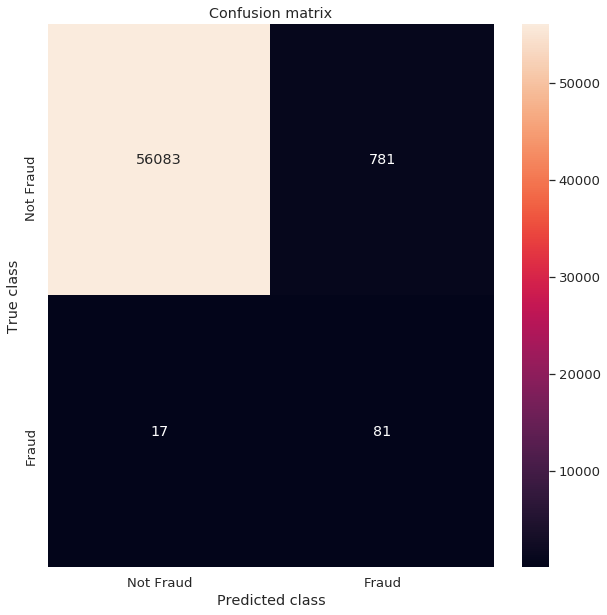

In [63]:
conf_matrix = confusion_matrix(error_df.true, y_pred)

sns.set(font_scale = 1.2)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, xticklabels=['Not Fraud','Fraud'], yticklabels=['Not Fraud','Fraud'], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

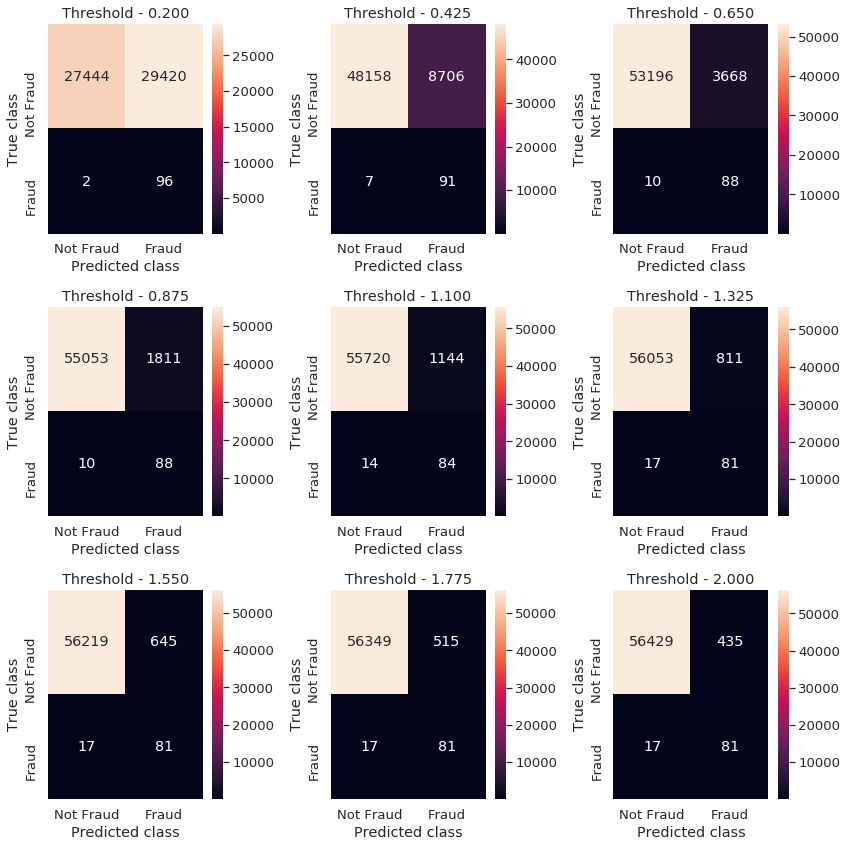

In [64]:
plt.figure(figsize=(12, 12))
m = []
for thresh in np.linspace(0.2,2,9):
    y_pred = [1 if e > thresh else 0 for e in error_df.error.values]
    conf_matrix = confusion_matrix(error_df.true, y_pred)
    m.append((conf_matrix,thresh))
    
count = 0
for i in range(3):
    for j in range(3):
        plt.subplot2grid((3, 3), (i, j))
        sns.heatmap(m[count][0], xticklabels=['Not Fraud','Fraud'], yticklabels=['Not Fraud','Fraud'], annot=True, fmt="d");
        plt.title(f"Threshold - {m[count][1]:.3f}")
        plt.ylabel('True class')
        plt.xlabel('Predicted class')
        plt.tight_layout()
        count += 1
plt.show()

In [66]:
thr = []
tp = []
fn = []
fp = []
tn = []
for thresh in np.linspace(0.2,3,200):
    y_pred = [1 if e > thresh else 0 for e in error_df.error.values]
    conf = confusion_matrix(error_df.true, y_pred)
    tp.append(conf[0][0])
    fp.append(conf[0][1])
    fn.append(conf[1][0])
    tn.append(conf[1][1])
    thr.append(thresh)

conf_df = pd.DataFrame(data = {'fp':fp,'fn':fn,'threshold':thr})
cdf = conf_df.drop_duplicates(subset='fn',keep='last')
print(cdf)

        fp  fn  threshold
3    22838   2   0.242211
4    21073   3   0.256281
6    17970   4   0.284422
9    14228   5   0.326633
17    8186   7   0.439196
22    6133   8   0.509548
28    4515   9   0.593970
55    1460  10   0.973869
59    1303  11   1.030151
62    1202  13   1.072362
64    1142  14   1.100503
65    1101  15   1.114573
75     878  16   1.255276
138    403  17   2.141709
169    308  18   2.577889
171    305  19   2.606030
199    244  20   3.000000


In [67]:
xx = [str(x) for x in cdf['fn'].values]
source = ColumnDataSource(data=dict(
    fn = xx,
    fp = cdf['fp'].values,
))

p = figure(plot_width = 800,
           toolbar_location = None, x_range = xx,
           title = "False Negative vs False Positive")

p.vbar(x = "fn", top = "fp", width = 0.9,
           color=Set3_12[3],  
           source=source)

p = format_plot(p, 'False Negatives', 'False Positive')

show(p);